Iantsa Provost et Bastien Soucasse ‚Äì Groupe 5

# Projet d'ACID ‚Äì 2 janvier 2022

## Introduction

Afin de se lancer dans la comparaison des diff√©rents algorithmes de _Machine Learning_, il nous faut des donn√©es √† exploiter pour l'entra√Ænement et en guise de test.

Commen√ßons par importer les modules et classes n√©cessaires au bon fonctionnement du projet.

In [5]:
from tensorflow.keras.datasets import fashion_mnist

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

import time

%matplotlib inline

VERBOSE = True

On peut alors r√©cup√©rer les donn√©es √† traiter √† l'aide de **keras**.

In [7]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

assert len(X_train.shape) == 3
assert len(X_test.shape) == 3
assert len(y_train.shape) == 1
assert len(y_test.shape) == 1

if (VERBOSE):
    print('X_train.shape =', X_train.shape)
    print('y_train.shape =', y_train.shape)
    print('X_test.shape =', X_test.shape)
    print('y_test.shape =', y_test.shape)

X_train.shape = (60000, 28, 28)
y_train.shape = (60000,)
X_test.shape = (10000, 28, 28)
y_test.shape = (10000,)


Si besoin, on peut avoir un aper√ßu des donn√©es.

X_train[0]:


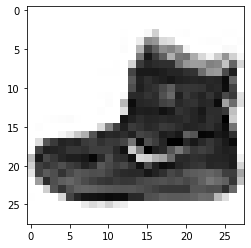

y_train[0] = 9
X_train[1]:


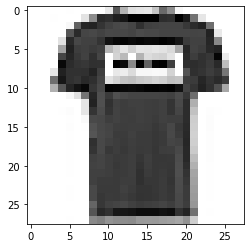

y_train[1] = 0
X_train[2]:


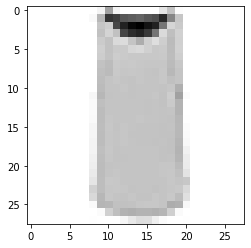

y_train[2] = 0
X_train[3]:


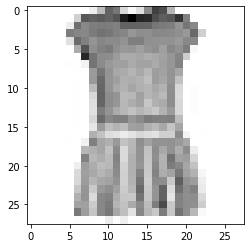

y_train[3] = 3
X_train[4]:


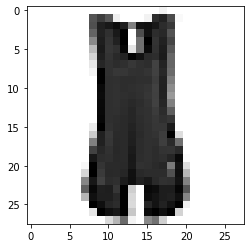

y_train[4] = 0


In [3]:
if VERBOSE:
    NUM_EXAMPLES = 5

    for i in range(NUM_EXAMPLES):
        print('X_train[%d]:' % i)
        plt.imshow(X_train[i], cmap = cm.Greys)
        plt.show()
        print('y_train[%d] =' % i, y_train[i])

On a √©galement besoin d'applatir les donn√©es.

In [8]:
X_train, X_test = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]), X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

assert len(X_train.shape) == 2
assert len(X_test.shape) == 2

if (VERBOSE):
    print('X_train.shape =', X_train.shape)
    print('X_test.shape =', X_test.shape)

X_train.shape = (60000, 784)
X_test.shape = (10000, 784)


## R√©ductions de dimension

Afin de comparer un large panel de classifications, on va mettre en place deux r√©ductions de dimensions qui seront appliqu√©es une √† une √† chaque mod√®le de classification. Cela permettra de tenter d'am√©liorer nos accuracy tout en gagnant du temps de calcul.

- Analyse en composantes principales
- Analyse lin√©aire discriminante

### Analyse en composantes principales

On commence par centrer les donn√©es.

In [5]:
scaler = StandardScaler()
X = np.concatenate((X_train, X_test))
z = scaler.fit_transform(X)

On peut maintenant commencer l'ACP.

In [6]:
pca = PCA()
coord = pca.fit_transform(z)

if VERBOSE:
    print('n_components =', pca.n_components_)

n_components = 784


Fions-nous au crit√®re du coude pour d√©finir le nombre d'axes que l'on va retenir. Pour ce faire, nous allons construire l'√©boulis des valeurs propres gr√¢ce √† une fonction.

In [7]:
def display_scree_plot(n_components, explained_variance_ratio):
    plt.grid()
    plt.plot(np.arange(1, n_components+1), explained_variance_ratio)
    plt.title('Scree Plot')
    plt.ylabel('Eigen Values')
    plt.xlabel('Factor Number')
    plt.show()

On peut ainsi afficher notre √©boulis et tenter de trouver le d√©crochement.

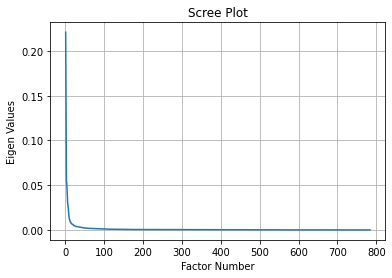

In [8]:
display_scree_plot(pca.n_components_, pca.explained_variance_ratio_)

En l'√©tat, l'√©boulis n'est pas vraiment lisible. Cependant, on remarque qu'√† partir d'un certain facteur, la valeur propre est plut√¥t constante. On peut donc tronquer cette partie, ce qui nous permettra de ¬´¬†zoomer¬†¬ª sur le d√©crochement que l'on cherche.

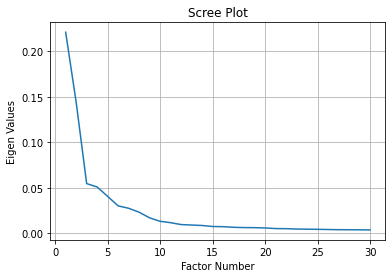

In [9]:
display_scree_plot(30, pca.explained_variance_ratio_[:30])

Nous ne sommes pas s√ªrs si le ¬´¬†d√©crochement¬†¬ª se fait plut√¥t pour la valeur 3 ou 6. Observons alors la variance totale pour ces valeurs. On va utiliser une fonction pour simplifier ce processus.

In [10]:
def display_total_variance(p):
    pca = PCA(n_components=p)
    pca.fit_transform(z)
    print('Total variance for p = %d: %.2f%%' % (p, pca.explained_variance_ratio_.sum() * 100))

On peut alors comparer nos deux valeurs.

In [11]:
display_total_variance(3)
display_total_variance(6)

Total variance for p = 3: 41.96%
Total variance for p = 6: 54.12%


Choisissons 6 car elle permet de garder au moins 50% de la variance.

Notons tout de m√™me que dans les 2 cas, le pourcentage de variance conserv√©e est plut√¥t bas. √âgalement, 6 est un nombre d'axes plut√¥t √©lev√©. On peut en d√©duire que l'ACP n'est s√ªrement pas la meilleure r√©duction de dimension.

In [12]:
ACP_N_COMPONENTS = 6

Et voil√†, notre ACP finale peut alors voir le jour.

In [13]:
pca = PCA(n_components=ACP_N_COMPONENTS)

X = np.concatenate((X_train, X_test))
z = scaler.fit_transform(X)
Xp = pca.fit_transform(z)
Xp_train = Xp[:X_train.shape[0]]
Xp_test = Xp[X_train.shape[0]:]

if VERBOSE:
    print('Xp_train.shape =', Xp_train.shape)
    print('Xp_test.shape =', Xp_test.shape)

Xp_train.shape = (60000, 6)
Xp_test.shape = (10000, 6)


### Analyse lin√©aire discriminante

En se basant sur le travail effectu√© pour r√©aliser l'ACP, on peut mettre en place l'ALD.

In [14]:
lda = LDA()

X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

X_lda = lda.fit_transform(X, y)
Xl_train = X_lda[:X_train.shape[0]]
Xl_test = X_lda[X_train.shape[0]:]

if VERBOSE:
    print('Xl_train.shape =', Xl_train.shape)
    print('Xl_test.shape =', Xl_test.shape)

Xl_train.shape = (60000, 9)
Xl_test.shape = (10000, 9)


Ratio de la variance expliqu√©e par les axes obtenus :

In [15]:
lda.explained_variance_ratio_

array([0.44775652, 0.21875177, 0.09237004, 0.07396008, 0.06062643,
       0.04305586, 0.03801965, 0.01584194, 0.00961772])

On peut en d√©duire qu'on garde 9 axes.

## Classifications des donn√©es

Cette partie est d√©di√©e concr√®tement au _Machine Learning_. Pour classifier les donn√©es on a plusieurs m√©thodes que l'on peut appliquer.

- M√©thode des _k_ plus proches voisins
- Classification na√Øve bay√©sienne
- Abre de d√©cision
- For√™t al√©atoire

### M√©thode des _k_ plus proches voisins

Gr√¢ce √† cette m√©thode, on regarde les classes d'un nombre donn√© de voisins les plus proches afin d'en d√©duire la classe de celui-ci. On va directement rechercher la meilleur valeur de _k_ possible parmi un ensemble d√©termin√© en amont.

#### Mise en place

On commence par d√©finir les valeurs possibles pour _k_.

In [16]:
K_VALS = list(range(1, 11)) + list(range(11, 101, 10))

if VERBOSE:
    print('K_VALS =', K_VALS)

K_VALS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 21, 31, 41, 51, 61, 71, 81, 91]


On peut r√©cup√©rer le temps d'entra√Ænement et l'accuracy pour le meilleur _k_ gr√¢ce √† une fonction. 

In [17]:
def find_best_knn(X_train, y_train, X_test, y_test, k_vals, patience=3):
    best_k, best_k_training_time, best_k_accuracy = 0, 0, 0
    p = patience

    for k in k_vals:
        if patience <= 0:
            break

        if VERBOSE:
            print('Computing %d-Nearest Neighbors classification‚Ä¶' % k)

        knn = KNeighborsClassifier(n_neighbors=k)
        start_time = time.time()
        knn.fit(X_train, y_train)
        training_time = time.time() - start_time
        accuracy = knn.score(X_test, y_test)

        if VERBOSE:
            print('training_time =', training_time)
            print('accuracy =', accuracy)
        
        if accuracy > best_k_accuracy:
            best_k = k
            best_k_training_time = training_time
            best_k_accuracy = accuracy
            p = patience + 1
        
        p -= 1
    
    return best_k, best_k_training_time, best_k_accuracy

#### Classification des donn√©es brutes

On calcule le temps d'entra√Ænement et l'accuracy du mod√®le _k_-NN pour le meilleur _k_ sur les donn√©es brutes.

In [18]:
# This is long so we use the value 4 computed previously.
# knn_k, knn_training_time, knn_accuracy = find_best_knn(X_train, y_train, X_test, y_test, K_VALS)
knn_k, knn_training_time, knn_accuracy = find_best_knn(X_train, y_train, X_test, y_test, [4])

print('%d-Nearest Neighbors:' % knn_k)
print('  - Training Time: %.2fs.' % knn_training_time)
print('  - Accuracy: %.2f%%.' % (knn_accuracy * 100))

Computing 4-Nearest Neighbors classification‚Ä¶
training_time = 0.06759381294250488
accuracy = 0.8577
4-Nearest Neighbors:
  - Training Time: 0.07s.
  - Accuracy: 85.77%.


On remarque que le meilleur mod√®le _k_-NN sur les donn√©es brutes est celui dont le _k_ vaut 4 et son accuracy est d'environ 86%. Quant aux autres valeurs de _k_, on constate malgr√© tout qu'on arrive g√©n√©ralement au del√† des 80% d'accuracy.

#### Classification apr√®s une ACP

On calcule le temps d'entra√Ænement et l'accuracy du mod√®le _k_-NN pour le meilleur _k_ apr√®s r√©duction de dimension gr√¢ce √† l'ACP.

In [19]:
pca_knn_k, pca_knn_training_time, pca_knn_accuracy = find_best_knn(Xp_train, y_train, Xp_test, y_test, K_VALS)

print('%d-Nearest Neighbors after PCA:' % pca_knn_k)
print('  - Training Time: %.2fs.' % pca_knn_training_time)
print('  - Accuracy: %.2f%%.' % (pca_knn_accuracy * 100))

Computing 1-Nearest Neighbors classification‚Ä¶
training_time = 0.019197940826416016
accuracy = 0.7205
Computing 2-Nearest Neighbors classification‚Ä¶
training_time = 0.016768932342529297
accuracy = 0.7169
Computing 3-Nearest Neighbors classification‚Ä¶
training_time = 0.016910791397094727
accuracy = 0.7427
Computing 4-Nearest Neighbors classification‚Ä¶
training_time = 0.016689777374267578
accuracy = 0.7507
Computing 5-Nearest Neighbors classification‚Ä¶
training_time = 0.016952037811279297
accuracy = 0.7558
Computing 6-Nearest Neighbors classification‚Ä¶
training_time = 0.016820907592773438
accuracy = 0.7591
Computing 7-Nearest Neighbors classification‚Ä¶
training_time = 0.016803979873657227
accuracy = 0.7641
Computing 8-Nearest Neighbors classification‚Ä¶
training_time = 0.016802072525024414
accuracy = 0.767
Computing 9-Nearest Neighbors classification‚Ä¶
training_time = 0.016701221466064453
accuracy = 0.767
Computing 10-Nearest Neighbors classification‚Ä¶
training_time = 0.01675796

On remarque que le meilleur mod√®le _k_-NN apr√®s r√©duction de dimension gr√¢ce √† l'ACP est celui dont le _k_ vaut 10 et son accuracy est d'environ 77%. Quant aux autres valeurs de _k_, on constate malgr√© tout qu'on arrive g√©n√©ralement au del√† des 70% d'accuracy.

#### Classification apr√®s une ALD

On calcule le temps d'entra√Ænement et l'accuracy du mod√®le _k_-NN pour le meilleur _k_ apr√®s r√©duction de dimension gr√¢ce √† l'ALD.

In [20]:
lda_knn_k, lda_knn_training_time, lda_knn_accuracy = find_best_knn(Xl_train, y_train, Xl_test, y_test, K_VALS)

print('%d-Nearest Neighbors after LDA:' % lda_knn_k)
print('  - Training Time: %.2fs.' % lda_knn_training_time)
print('  - Accuracy: %.2f%%.' % (lda_knn_accuracy * 100))

Computing 1-Nearest Neighbors classification‚Ä¶
training_time = 0.018815994262695312
accuracy = 0.7935
Computing 2-Nearest Neighbors classification‚Ä¶
training_time = 0.017714977264404297
accuracy = 0.8025
Computing 3-Nearest Neighbors classification‚Ä¶
training_time = 0.0178220272064209
accuracy = 0.8177
Computing 4-Nearest Neighbors classification‚Ä¶
training_time = 0.01764988899230957
accuracy = 0.8259
Computing 5-Nearest Neighbors classification‚Ä¶
training_time = 0.01783299446105957
accuracy = 0.8293
Computing 6-Nearest Neighbors classification‚Ä¶
training_time = 0.017623186111450195
accuracy = 0.8328
Computing 7-Nearest Neighbors classification‚Ä¶
training_time = 0.01789116859436035
accuracy = 0.8363
Computing 8-Nearest Neighbors classification‚Ä¶
training_time = 0.01773381233215332
accuracy = 0.8363
Computing 9-Nearest Neighbors classification‚Ä¶
training_time = 0.017499685287475586
accuracy = 0.8396
Computing 10-Nearest Neighbors classification‚Ä¶
training_time = 0.017632007598

On remarque alors que le meilleur mod√®le _k_-NN apr√®s r√©duction de dimension gr√¢ce √† l'ALD est celui dont le _k_ vaut 41 et son accuracy est d'environ 84%. Quant aux autres valeurs de _k_, on constate malgr√© tout qu'on arrive g√©n√©ralement au del√† des 80% d'accuracy.

### Classification na√Øve bay√©sienne

La classification na√Øve bay√©sienne se base sur le Th√©or√®me de Bayes pour classifier les donn√©es, en consid√©rant chaque caract√©ristique (ici pixel) ind√©pendamment des autres.

#### Mise en place

On peut r√©cup√©rer le temps d'entra√Ænement et l'accuracy gr√¢ce √† une fonction.

In [21]:
def find_nb(X_train, y_train, X_test, y_test):
    if VERBOSE:
        print('Computing naive Bayes classification‚Ä¶')

    nb = GaussianNB()
    start_time = time.time()
    nb.fit(X_train, y_train)
    nb_training_time = time.time() - start_time
    nb_accuracy = nb.score(X_test, y_test)

    if VERBOSE:
        print('training_time =', nb_training_time)
        print('accuracy =', nb_accuracy)
    
    return nb_training_time, nb_accuracy

#### Classification des donn√©es brutes

On calcule le temps d'entra√Ænement et l'accuracy du mod√®le NB sur les donn√©es brutes.

In [22]:
nb_training_time, nb_accuracy = find_nb(X_train, y_train, X_test, y_test)

print('Naive Bayes:')
print('  - Training Time: %.2fs.' % nb_training_time)
print('  - Accuracy: %.2f%%.' % (nb_accuracy * 100))

Computing naive Bayes classification‚Ä¶
training_time = 0.2632157802581787
accuracy = 0.5856
Naive Bayes:
  - Training Time: 0.26s.
  - Accuracy: 58.56%.


On remarque que le mod√®le NB sur les donn√©es brutes a une accuracy d'environ 59%.

#### Classification apr√®s une ACP

On calcule le temps d'entra√Ænement et l'accuracy du mod√®le NB apr√®s r√©duction de dimension gr√¢ce √† l'ACP.

In [23]:
pca_nb_training_time, pca_nb_accuracy = find_nb(Xp_train, y_train, Xp_test, y_test)

print('Naive Bayes after PCA:')
print('  - Training Time: %.2fs.' % pca_nb_training_time)
print('  - Accuracy: %.2f%%.' % (pca_nb_accuracy * 100))

Computing naive Bayes classification‚Ä¶
training_time = 0.010617256164550781
accuracy = 0.6772
Naive Bayes after PCA:
  - Training Time: 0.01s.
  - Accuracy: 67.72%.


On remarque que le mod√®le NB apr√®s r√©duction de dimensions gr√¢ce √† l'ACP a une accuracy d'environ 68%.

#### Classification apr√®s une ALD

On calcule le temps d'entra√Ænement et l'accuracy du mod√®le NB apr√®s r√©duction de dimension gr√¢ce √† l'ALD.

In [24]:
lda_nb_training_time, lda_nb_accuracy = find_nb(Xl_train, y_train, Xl_test, y_test)

print('Naive Bayes after LDA:')
print('  - Training Time: %.2fs.' % lda_nb_training_time)
print('  - Accuracy: %.2f%%.' % (lda_nb_accuracy * 100))

Computing naive Bayes classification‚Ä¶
training_time = 0.009877204895019531
accuracy = 0.8172
Naive Bayes after LDA:
  - Training Time: 0.01s.
  - Accuracy: 81.72%.


On remarque que le mod√®le NB apr√®s r√©duction de dimensions gr√¢ce √† l'ALD a une accuracy d'environ 82%.

On constate un meilleur temps de calcul que sans r√©duction de dimension, mais dans les m√™mes eaux qu'avec une ACP. 

N√©anmoins une nette am√©lioration se d√©marque au niveau de l'accuracy. En effet, on gagne : 
- plus de 20% par rapport √† une classification bay√©sienne sans r√©duction de dimension ;
- plus de 10% par rapport √† une classification bay√©sienne avec ACP.

### Arbre de d√©cision

Cette m√©thode est souvent pr√©f√©r√©e lorsque l'interpr√©tabilit√© des r√©sultats est plus importante que la performance. Or ici, il semble que la performance nous importe plus. De plus, comme on travaille sur des images et que chaque pixel fait office de descripteur, on a de tr√®s grandes chances de se retrouver avec un arbre tr√®s touffu et donc assez long √† construire. Ce n'est donc s√ªrement pas la meilleure m√©thode √† utiliser, du moins peut-√™tre pas avant r√©duction de dimension. Testons cela.

#### Mise en place

On peut r√©cup√©rer le temps d'entra√Ænement et l'accuracy gr√¢ce √† une fonction, qui utilise dans un premier temps les hyper param√®tres par d√©faut d'un classifieur arbre de d√©cision.

In [25]:
def find_dt(X_train, y_train, X_test, y_test, params=None):
    if VERBOSE:
        if params == None:
            print('Computing Decision Tree classification‚Ä¶')
        else:
            print('Computing %s Decision Tree classification‚Ä¶' % params)

    if params == None:
        dt = DecisionTreeClassifier()
    else:
        dt = DecisionTreeClassifier(
                        criterion=params[0],
                        max_depth=params[1],
                        min_samples_leaf=params[2],
                        min_samples_split=params[3]
                    )

    start_time = time.time()
    dt.fit(X_train, y_train)
    dt_training_time = time.time() - start_time
    dt_accuracy = dt.score(X_test, y_test)

    if VERBOSE:
        print('training_time =', dt_training_time)
        print('accuracy =', dt_accuracy)
    
    return dt_training_time, dt_accuracy, dt.tree_.max_depth

#### Classification (initiale) des donn√©es brutes

On calcule le temps d'entra√Ænement et l'accuracy du mod√®le DT initial sur les donn√©es brutes.

In [26]:
default_dt_training_time, default_dt_accuracy, dt_max_depth = find_dt(X_train, y_train, X_test, y_test)

print('Decision Tree:')
print('  - Training Time: %.2fs.' % default_dt_training_time)
print('  - Accuracy: %.2f%%.' % (default_dt_accuracy * 100))

Computing Decision Tree classification‚Ä¶
training_time = 26.394428730010986
accuracy = 0.7917
Decision Tree:
  - Training Time: 26.39s.
  - Accuracy: 79.17%.


On remarque que le mod√®le DT initial sur les donn√©es brutes a une accuracy d'environ 79%.

Comme on l'avait pr√©dit, le temps de calcul est consid√©rablement important compar√© aux 2 m√©thodes test√©es pr√©c√©demment (entre 30 secondes et 1 minute). Cependant on obtient une accuracy :
- bien meilleure que celle d'une classification bay√©sienne ;
- l√©g√®rement inf√©rieure √† celle du meilleur mod√®le de k-NN. 

#### Optimisation

Voyons si on peut am√©liorer ce mod√®le en changeant les hyper param√®tres, sachant que par d√©faut ils sont d√©finis comme ci-dessous :
- `criterion='gini'`
- `max_depth=None`
- `min_samples_leaf=1`
- `min_samples_split=2`

Nous avons √©galement besoin de calculer la profondeur pas d√©faut.

In [27]:
if VERBOSE:
    print('dt_max_depth =', dt_max_depth)

dt_max_depth = 49

On trouve donc une profondeur de 49 par d√©faut.

√âlaborons une nouvelle fonction qui permet de trouver le meilleur mod√®le d'arbre de d√©cision.

In [9]:
criterion = ['gini', 'entropy']
max_depth = [3, 5, 10]
min_samples_leaf = [1, 2, 5]
min_samples_split = [2, 3, 4]

def find_best_dt(X_train, y_train, X_test, y_test):
    best_params = None
    best_dt_training_time, best_dt_accuracy = 0, 0

    for c in criterion:
        for depth in max_depth:
            for l in min_samples_leaf:
                for s in min_samples_split:

                    params = [c, depth, l, s]
                    dt_training_time, dt_accuracy, _ = find_dt(X_train, y_train, X_test, y_test, params)

                    if best_dt_accuracy == 0 or dt_accuracy > best_dt_accuracy:
                        best_params = params
                        best_dt_training_time = dt_training_time
                        best_dt_accuracy = dt_accuracy
                        

    if VERBOSE:
        print('parameters:', best_params)
        print('training_time =', best_dt_training_time)
        print('accuracy =', best_dt_accuracy)
    
    return best_params, best_dt_training_time, best_dt_accuracy

Nous avons √©labor√© cette fonction dans un premier temps, avant de trouver une m√©thode plus propre √† l'aide de `RandomizedSearchCV`. On va √©galement utiliser cette m√©thode pour v√©rifier et/ou comparer les r√©sultats.

On commence par cr√©er la _random grid_.

In [10]:
random_grid = {
    'criterion': criterion,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split
}

if VERBOSE:
    print(random_grid)

{'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 10], 'min_samples_leaf': [1, 2, 5], 'min_samples_split': [2, 3, 4]}


Une fois cr√©√©e on peut proc√©der √† la recherche des meilleurs hyper param√®tres.

In [12]:
dt = DecisionTreeClassifier()
dt_random = RandomizedSearchCV(
                        estimator=dt,
                        param_distributions=random_grid,
                        cv=3,
                        verbose=2,
                        random_state=42,
                        n_jobs=-1 
                    )
dt_random.fit(X_train, y_train)

if VERBOSE:
        print('best_params', dt_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=3; total time=  43.6s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=3; total time=  44.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=3; total time=  44.6s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=3; total time=  53.7s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=3; total time=  48.3s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=2; total time=  47.8s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=3; total time=  48.5s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=2; total time=  49.4s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=2; total time=  19.7s
[CV] END criterion=gini, max_depth

Il semble bon de pr√©ciser malgr√© tout que, quelque soit la m√©thode utilis√©e (manuelle ou ¬´¬†Grid Search¬†¬ª), la recherche du meilleur mod√®le DT est limit√©e par nos choix d'hyper param√®tres √† tester. En effet, le temps de calcul √©tant d√©j√† suffisamment long, nous avons d√ª choisir lesquels appliquer. Tous ne seront dont pas test√©s.

#### Classification (optimis√©e) des donn√©es brutes

On calcule le temps d'entra√Ænement et l'accuracy du mod√®le DT optimis√© sur les donn√©es brutes, avec notre version manuelle.

In [29]:
best_dt_params, best_dt_training_time, best_dt_accuracy = find_best_dt(X_train, y_train, X_test, y_test)

print('Best Decision Tree:')
print('  - Training Time: %.2fs.' % best_dt_training_time)
print('  - Accuracy: %.2f%%.' % (best_dt_accuracy * 100))

Computing ['gini', 3, 1, 2] Decision Tree classification‚Ä¶
training_time = 3.737954616546631
accuracy = 0.4988
Computing ['gini', 3, 1, 3] Decision Tree classification‚Ä¶
training_time = 3.716620922088623
accuracy = 0.4988
Computing ['gini', 3, 1, 4] Decision Tree classification‚Ä¶
training_time = 3.722123861312866
accuracy = 0.4988
Computing ['gini', 3, 2, 2] Decision Tree classification‚Ä¶
training_time = 4.044227123260498
accuracy = 0.4988
Computing ['gini', 3, 2, 3] Decision Tree classification‚Ä¶
training_time = 3.7708849906921387
accuracy = 0.4988
Computing ['gini', 3, 2, 4] Decision Tree classification‚Ä¶
training_time = 3.7946438789367676
accuracy = 0.4988
Computing ['gini', 3, 5, 2] Decision Tree classification‚Ä¶
training_time = 3.89794921875
accuracy = 0.4988
Computing ['gini', 3, 5, 3] Decision Tree classification‚Ä¶
training_time = 3.8051912784576416
accuracy = 0.4988
Computing ['gini', 3, 5, 4] Decision Tree classification‚Ä¶
training_time = 3.7640228271484375
accuracy =

On remarque de le mod√®le DT optimis√© sur les donn√©es brutes a une accuracy d'environ 81%. On retrouve √©galement le m√™me meilleur mod√®le que celui calcul√© par la m√©thode ¬´¬†Grid Search¬†¬ª.

On va faire la m√™me chose en utilisant cette fois le meilleur mod√®le calcul√© avec la m√©thode ¬´¬†Grid Search¬†¬ª.

In [ ]:
best_dt_params, best_dt_training_time, best_dt_accuracy = find_dt(X_train, y_train, X_test, y_test, dt_random.best_params_)

print('Best Decision Tree:')
print('  - Training Time: %.2fs.' % best_dt_training_time)
print('  - Accuracy: %.2f%%.' % (best_dt_accuracy * 100))

On ne peut que remarquer que le temps de calcul est beaucoup moins long. Pour gagner du temps, on va garder la m√©thode ¬´¬†Grid Search¬†¬ª d√©sormais. Sauvegardons les meilleurs hyper param√®tres que l'on a obtenus pour ce test.

In [13]:
BEST_DT_PARAMS = {
    'criterion': 'entropy',
    'max_depth': 10,
    'min_samples_leaf': 2,
    'min_samples_split': 3
}

En outre, on constate qu'en passant d'une profondeur de 49 √† 10, on obtient une accuracy l√©g√®rement am√©lior√©e ainsi qu'un temps de calcul divis√© par 2 approximativement.

En regardant un peu tous les mod√®les (une occurrence a √©t√© sauvegard√©e dans le fichier `find_best_dt.txt` car le temps de recherche est tr√®s long), on remarque notamment que :
- c'est surtout le param√®tre `max_depth` qui a une r√©elle influence sur l'accuracy et le temps de calcul ;
- tous les mod√®les `max_depth=10` ont des r√©sultats similaires.

Enfin, on sauvegarde √©galement le temps d'entra√Ænement et l'accuracy de la meilleure version, √† savoir celle utilisant les meilleurs hyper param√®tres.

In [ ]:
dt_training_time, dt_accuracy = best_dt_training_time, best_dt_accuracy

#### Classification apr√®s une ACP

On calcule le temps d'entra√Ænement et l'accuracy du mod√®le DT initial apr√®s r√©duction de dimension gr√¢ce √† l'ACP.

In [31]:
pca_default_dt_training_time, pca_default_dt_accuracy, _ = find_dt(Xp_train, y_train, Xp_test, y_test)

print('Decision Tree after PCA:')
print('  - Training Time: %.2fs.' % pca_default_dt_training_time)
print('  - Accuracy: %.2f%%.' % (pca_default_dt_accuracy * 100))

Computing Decision Tree classification‚Ä¶
training_time = 0.49593091011047363
accuracy = 0.6966
Decision Tree after PCA:
  - Training Time: 0.50s.
  - Accuracy: 69.66%.


On remarque que le mod√®le DT initial apr√®s r√©duction de dimension gr√¢ce √† l'ACP a une accuracy d'environ 70%.

On fait de m√™me avec la version optimis√©e.

In [32]:
pca_best_dt_training_time, pca_best_dt_accuracy, _ = find_dt(Xp_train, y_train, Xp_test, y_test, BEST_DT_PARAMS)

print('Best Decision Tree after PCA:')
print('  - Training Time: %.2fs.' % pca_best_dt_training_time)
print('  - Accuracy: %.2f%%.' % (pca_best_dt_accuracy * 100))

Computing ['entropy', 10, 2, 3] Decision Tree classification‚Ä¶
training_time = 0.4896390438079834
accuracy = 0.7269
Best Decision Tree after PCA:
  - Training Time: 0.49s.
  - Accuracy: 72.69%.


On remarque que le mod√®le DT optimis√© apr√®s r√©duction de dimension gr√¢ce √† l'ACP a une accuracy d'environ 73%.

Dans les 2 cas, on observe qu'on a consid√©rablement diminu√© le temps de calcul, compar√© au m√™me mod√®le sans r√©duction de dimension. N√©anmoins, l'accuracy a embo√Æt√© le pas. En effet, on a perdu 10% d'accuracy, en obtenant d√©sormais environ 70%. Par cons√©quent, ces 2 mod√®les semblent plut√¥t √©quivalents, et sont meilleurs que le m√™me mod√®le sans r√©duction de dimension.

On va comme pr√©c√©demment sauvegarder le temps d'entra√Ænement et l'accuracy du mod√®le avec les meilleurs hyper param√®tres.

In [ ]:
pca_dt_training_time, pca_dt_accuracy = pca_best_dt_training_time, pca_best_dt_accuracy

#### Classification apr√®s une ALD

On calcule le temps d'entra√Ænement et l'accuracy du mod√®le DT initial apr√®s une r√©duction de dimension gr√¢ce √† l'ALD.

In [33]:
lda_default_dt_training_time, lda_default_dt_accuracy, _ = find_dt(Xl_train, y_train, Xl_test, y_test)

print('Decision Tree after LDA:')
print('  - Training Time: %.2fs.' % lda_default_dt_training_time)
print('  - Accuracy: %.2f%%.' % (lda_default_dt_accuracy * 100))

Computing Decision Tree classification‚Ä¶
training_time = 0.7852098941802979
accuracy = 0.777
Decision Tree after LDA:
  - Training Time: 0.79s.
  - Accuracy: 77.70%.


On remarque que le mod√®le DT initial apr√®s une r√©duction de dimension gr√¢ce √† l'ALD a une accuracy d'environ 78%.

On observe un temps de calcul similaire au mod√®le avec ACP, donc beaucoup plus court que le mod√®le sans r√©duction de dimension. De plus, l'accuracy se rapproche d√©sormais plus de 80% que de 70% contrairement au mod√®le avec ACP, pour un m√™me temps de calcul. Ce mod√®le semble donc meilleur.

On fait de m√™me avec la version optimis√©e.

In [34]:
lda_best_dt_training_time, lda_best_dt_accuracy, _ = find_dt(Xl_train, y_train, Xl_test, y_test, BEST_DT_PARAMS)

print('Best Decision Tree after LDA:')
print('  - Training Time: %.2fs.' % lda_best_dt_training_time)
print('  - Accuracy: %.2f%%.' % (lda_best_dt_accuracy * 100))

Computing ['entropy', 10, 2, 3] Decision Tree classification‚Ä¶
training_time = 0.6848828792572021
accuracy = 0.8136
Best Decision Tree after LDA:
  - Training Time: 0.68s.
  - Accuracy: 81.36%.


On remarque que le mod√®le DT optimis√© apr√®s une r√©duction de dimension gr√¢ce √† l'ALD a une accuracy d'environ 81%.

Le mod√®le avec les meilleurs param√®tres a quant √† lui une accuracy qui passe la barre des 80%, cela reste tout de m√™me similaire au mod√®le pr√©c√©dent. Le temps de calcul est √©galement similaire. On peut consid√©rer que ce mod√®le est meilleur (mais on n'est pas √† 4% pr√®s‚Ä¶). On va donc sauvegarder ses valeurs.

In [ ]:
lda_dt_training_time, lda_dt_accuracy = lda_best_dt_training_time, lda_best_dt_accuracy

### For√™t al√©atoire

Ici, on utilise un ensemble d'arbres de d√©cision, entra√Æn√©s sur des sous-ensembles de donn√©es l√©g√®rement diff√©rents.

#### Mise en place

On peut r√©cup√©rer le temps d'entra√Ænement et l'accuracy gr√¢ce √† une fonction, qui, de la m√™me mani√®re qu'avec les arbres de d√©cision, utilise dans un premier temps les hyper param√®tres par d√©faut d'un classifieur for√™t al√©atoire.

In [35]:
def find_rf(X_train, y_train, X_test, y_test):
    if VERBOSE:
        print('Computing Random Forest classification‚Ä¶')
    
    rf = RandomForestClassifier()
    start_time = time.time()
    rf.fit(X_train, y_train)
    rf_training_time = time.time() - start_time
    rf_accuracy = rf.score(X_test, y_test)

    if VERBOSE:
        print('training_time =', rf_training_time)
        print('accuracy =', rf_accuracy)
    
    return rf_training_time, rf_accuracy

#### Classification (initiale) des donn√©es brutes

On calcule le temps d'entra√Ænement et l'accuracy du mod√®le RF initial sur les donn√©es brutes.

In [36]:
default_rf_training_time, default_rf_accuracy = find_rf(X_train, y_train, X_test, y_test)

print('Random Forest:')
print('  - Training Time: %.2fs.' % default_rf_training_time)
print('  - Accuracy: %.2f%%.' % (default_rf_accuracy * 100))

Computing Random Forest classification‚Ä¶
training_time = 50.29429817199707
accuracy = 0.8761
Random Forest:
  - Training Time: 50.29s.
  - Accuracy: 87.61%.


On remarque que le mod√®le RF initial sur les donn√©es brutes a une accuracy d'environ 88%.

C'est le plus long temps de calcul obtenu jusqu'ici, mais aussi la meilleure accuracy. Il est s√ªrement possible d'am√©liorer ce mod√®le en changeant les hyper param√®tres.

#### Optimisation

On a vu pr√©c√©dement, avec les arbres de d√©cision, qu'une recherche ¬´¬†exhaustive¬†¬ª √©tait plut√¥t longue. Nous allons utiliser uniquement la m√©thode ¬´¬†Grid Search¬†¬ª cette fois.

Par d√©faut, les hyper param√®tres sont d√©finis comme ci-dessous :

- `n_estimators=100`
- `max_features='auto'`
- `max_depth=None`
- `min_samples_split=2`
- `min_samples_leaf=1`
- `bootstrap=True`

On commence par cr√©er la _random grid_.

In [37]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

if VERBOSE:
    print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


On r√©cup√®re ensuite les meilleurs hyper param√®tres.

In [38]:
# This is long so we only did it once.

if False:
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv=3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train, y_train)

    if VERBOSE:
        print('best_params', rf_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 2.6min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 2.6min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 3.1min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=12.2min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=11.3min
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 2.1min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

Comme pr√©c√©demment, on rappelle que la recherche du meilleur mod√®le RF est limit√©e par nos choix d'hyper param√®tres √† tester √† cause du temps de calcul d√©j√† extr√®mement √©lev√©.

On sauvegarde les meilleurs hyper param√®tres.

In [39]:
BEST_RF_PARAMS = {
    'n_estimators': 600,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_features': 'auto',
    'max_depth': 70,
    'bootstrap': False
}

√âlaborons une nouvelle fonction qui permet de r√©cup√©rer le temps d'entra√Ænement et l'accuracy du meilleur mod√®le de for√™t al√©atoire.

In [40]:
def find_rf_optimized(X_train, y_train, X_test, y_test):
    if VERBOSE:
        print('Computing Random Forest classification‚Ä¶')

    rf = RandomForestClassifier(
        n_estimators=BEST_RF_PARAMS.get('n_estimators'),
        max_features=BEST_RF_PARAMS.get('max_features'),
        max_depth=BEST_RF_PARAMS.get('max_depth'),
        min_samples_split=BEST_RF_PARAMS.get('min_samples_split'),
        min_samples_leaf=BEST_RF_PARAMS.get('min_samples_leaf'),
        bootstrap=BEST_RF_PARAMS.get('bootstrap'),
    )
    start_time = time.time()
    rf.fit(X_train, y_train)
    rf_training_time = time.time() - start_time
    rf_accuracy = rf.score(X_test, y_test)

    if VERBOSE:
        print('parameters:', BEST_RF_PARAMS)
        print('training_time =', rf_training_time)
        print('accuracy =', rf_accuracy)
    
    return rf_training_time, rf_accuracy

#### Classification (optimis√©e) des donn√©es brutes

On calcule le temps d'entra√Ænement et l'accuracy du mod√®le RF optimis√© sur les donn√©es brutes.

In [41]:
best_rf_training_time, best_rf_accuracy = find_rf_optimized(X_train, y_train, X_test, y_test)

print('Best Random Forest:')
print('  - Training Time: %.2fs.' % best_rf_training_time)
print('  - Accuracy: %.2f%%.' % (best_rf_accuracy * 100))

Computing Random Forest classification‚Ä¶
parameters: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': False}
training_time = 468.4499728679657
accuracy = 0.8839
Best Random Forest:
  - Training Time: 468.45s.
  - Accuracy: 88.39%.


On remarque que le mod√®le RF optimis√© apr√®s r√©duction de dimension gr√¢ce √† l'ACP a une accuracy d'environ 88%.

La version utilisant les meilleurs hyper param√®tres possibles parmi ceux fournis via la _random grid_ semble obtenir un r√©sultat √† peine meilleur voire √©quivalent √† ce niveau de diff√©rence. Cependant, le temps d'entra√Ænement a √©t√© drastiquement augment√©. On peut donc consid√©rer ce mod√®le comme moins performant que celui utilisant les param√®tres par d√©faut. On sauvegarde donc la version initiale.

In [ ]:
rf_training_time, rf_accuracy = default_rf_training_time, default_rf_accuracy

#### Classification apr√®s une ACP

On calcule le temps d'entra√Ænement et l'accuracy du mod√®le RF initial apr√®s r√©duction de dimension gr√¢ce √† l'ACP.

In [42]:
pca_default_rf_training_time, pca_default_rf_accuracy = find_rf(Xp_train, y_train, Xp_test, y_test)

print('Random Forest after PCA:')
print('  - Training Time: %.2fs.' % pca_default_rf_training_time)
print('  - Accuracy: %.2f%%.' % (pca_default_rf_accuracy * 100))

Computing Random Forest classification‚Ä¶
training_time = 10.328389167785645
accuracy = 0.7784
Random Forest after PCA:
  - Training Time: 10.33s.
  - Accuracy: 77.84%.


On remarque que le mod√®le RF initial apr√®s r√©duction de dimension gr√¢ce √† l'ACP a une accuracy d'environ 78%.

On fait de m√™me avec la version optimis√©e.

In [43]:
pca_best_rf_training_time, pca_best_rf_accuracy = find_rf_optimized(Xp_train, y_train, Xp_test, y_test)

print('Best Random Forest after PCA:')
print('  - Training Time: %.2fs.' % pca_best_rf_training_time)
print('  - Accuracy: %.2f%%.' % (pca_best_rf_accuracy * 100))

Computing Random Forest classification‚Ä¶
parameters: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': False}
training_time = 99.56964087486267
accuracy = 0.7791
Best Random Forest after PCA:
  - Training Time: 99.57s.
  - Accuracy: 77.91%.


On remarque que le mod√®le RF optimis√© apr√®s r√©duction de dimension gr√¢ce √† l'ACP a une accuracy d'environ 78%.

Ici, on retrouve comme sur les donn√©es brutes, une accuracy √©quivalente √† la version par d√©faut, mais un temps d'entra√Ænement bien plus √©lev√©. Il n'est donc pas non plus rentable d'utiliser un tel mod√®le.

In [ ]:
pca_rf_training_time, pca_rf_accuracy = pca_default_rf_training_time, pca_default_rf_accuracy

#### Classification apr√®s une ALD

On calcule le temps d'entra√Ænement et l'accuracy du mod√®le RF initial apr√®s r√©duction de dimension gr√¢ce √† l'ALD.

In [44]:
lda_default_rf_training_time, lda_default_rf_accuracy = find_rf(Xl_train, y_train, Xl_test, y_test)

print('Random Forest after LDA:')
print('  - Training Time: %.2fs.' % lda_default_rf_training_time)
print('  - Accuracy: %.2f%%.' % (lda_default_rf_accuracy * 100))

Computing Random Forest classification‚Ä¶
training_time = 16.171419858932495
accuracy = 0.8382
Random Forest after LDA:
  - Training Time: 16.17s.
  - Accuracy: 83.82%.


On remarque que le mod√®le RF initial apr√®s r√©duction de dimension gr√¢ce √† l'ALD a une accuracy d'environ 84%.

On fait de m√™me avec la version optimis√©e.

In [45]:
lda_best_rf_training_time, lda_best_rf_accuracy = find_rf_optimized(Xl_train, y_train, Xl_test, y_test)

print('Best Random Forest after LDA:')
print('  - Training Time: %.2fs.' % lda_best_rf_training_time)
print('  - Accuracy: %.2f%%.' % (lda_best_rf_accuracy * 100))

Computing Random Forest classification‚Ä¶
parameters: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': False}
training_time = 158.083811044693
accuracy = 0.8404
Best Random Forest after LDA:
  - Training Time: 158.08s.
  - Accuracy: 84.04%.


On remarque que le mod√®le RF optimis√© apr√®s r√©duction de dimension gr√¢ce √† l'ALD a une accuracy d'environ 84%.

Encore une fois, on se retrouve avec moins de 1% d'accuracy de diff√©rence, mais un temps d'entra√Ænement beaucoup trop long pour faire de ce mod√®le un meilleur que celui par d√©faut.

In [ ]:
lda_rf_training_time, lda_rf_accuracy = lda_default_rf_training_time, lda_default_rf_accuracy

## Conclusion

√Ä partir des accuracy calcul√©es dans la partie pr√©c√©dente, il est possible de d√©terminer quelles sont les meilleures pour ces donn√©es.

On peut trier toutes les accuracy par ordre d√©croissant.

In [46]:
models = {
    '%d-Nearest Neighbors' % knn_k: (knn_training_time, knn_accuracy),
    '%d-Nearest Neighbors after PCA' % pca_knn_k: (pca_knn_training_time, pca_knn_accuracy),
    '%d-Nearest Neighbors after LDA' % lda_knn_k: (lda_knn_training_time, lda_knn_accuracy),
    'Naive Bayes': (nb_training_time, nb_accuracy),
    'Naive Bayes after PCA': (pca_nb_training_time, pca_nb_accuracy),
    'Naive Bayes after LDA': (lda_nb_training_time, lda_nb_accuracy),
    'Decision Tree': (dt_training_time, dt_accuracy),
    'Decision Tree after PCA': (pca_dt_training_time, pca_dt_accuracy),
    'Decision Tree after LDA': (lda_dt_training_time, lda_dt_accuracy),
    'Random Forest': (rf_training_time, rf_accuracy),
    'Random Forest after PCA': (pca_rf_training_time, pca_rf_accuracy),
    'Random Forest after LDA': (lda_rf_training_time, lda_rf_accuracy)
}

models = dict(sorted(models.items(), key=lambda item: item[1][1], reverse=True))

On peut alors d√©terminer quels sont les meilleurs mod√®les de classification, selon leur accuracy.

In [47]:
print('Best Models:')

i = 0

for model in models:
    i += 1
    print('  #%d: %s, with a training time of %.2fs and an accuracy of %.2f%%.' % (i, model, models.get(model)[0], models.get(model)[1] * 100))

Best Models:
  #1: Random Forest, with a training time of 468.45s and an accuracy of 88.39%.
  #2: 4-Nearest Neighbors, with a training time of 0.07s and an accuracy of 85.77%.
  #3: 41-Nearest Neighbors after LDA, with a training time of 0.02s and an accuracy of 84.15%.
  #4: Random Forest after LDA, with a training time of 158.08s and an accuracy of 84.04%.
  #5: Naive Bayes after LDA, with a training time of 0.01s and an accuracy of 81.72%.
  #6: Decision Tree after LDA, with a training time of 0.68s and an accuracy of 81.36%.
  #7: Decision Tree, with a training time of 12.64s and an accuracy of 81.17%.
  #8: Random Forest after PCA, with a training time of 99.57s and an accuracy of 77.91%.
  #9: 10-Nearest Neighbors after PCA, with a training time of 0.02s and an accuracy of 76.91%.
  #10: Decision Tree after PCA, with a training time of 0.49s and an accuracy of 72.69%.
  #11: Naive Bayes after PCA, with a training time of 0.01s and an accuracy of 67.72%.
  #12: Naive Bayes, with 

On a donc tous nos mod√®les tri√©s par meilleure accuracy. On remarque que RF semble √™tre le meilleur mod√®le sur les donn√©es brutes, mais relativement long, il semble √™tre aussi le meilleur apr√®s r√©duction de dimension gr√¢ce √† l'ACP ; et _k_-NN semble √™tre le meilleur apr√®s r√©duction de dimension gr√¢ce √† l'ALD.

On remarque √©galement que les mod√®les apr√®s ACP sont peu performants par rapport aux autres, et que _k_-NN est un tr√®s bon mod√®le quelles que soient les donn√©es.

Il semble cependant bon de noter que √† accuracy relativement similaire, il est pr√©f√©rable de choisir un classifieur ayant un temps d'ex√©cution plus court. En effet, ce qui compte le plus est le rapport accuracy/temps d'entra√Ænement.

Et voil√† le travail ! üôÇ